# Chapter 3 データ分析と視覚化：山梨県の気象データで学ぶ

## 可視化で利用するライブラリのインストール

データ分析には様々なライブラリが必要です。ここでは、最も一般的に使用されるいくつかのライブラリをインストールします。

- `numpy`: 数値計算を効率的に行うためのライブラリです。多次元配列の操作や科学計算機能が豊富に提供されています。
- `pandas`: データ分析とデータ操作を容易にするためのライブラリです。データフレームという強力なデータ構造を提供し、データの読み込み、加工、集計などが行えます。
- `matplotlib`: データをグラフやチャートとして可視化するためのライブラリです。柔軟なカスタマイズが可能で、多様なグラフを作成できます。
- `seaborn`: `matplotlib`に基づく統計的グラフを描画するためのライブラリです。より美しいグラフを簡単に作成できるように設計されています。

Open Meteoは気象データへのアクセスを提供するAPIです。このAPIを利用するためには特定のライブラリが必要です。

- `openmeteo-requests`: Open Meteo APIに簡単にアクセスするためのライブラリです。気象データの取得と操作を効率的に行うことができます。
- `requests-cache`: HTTPリクエストの結果をキャッシュするためのライブラリです。APIから同じデータを何度もリクエストする場合、キャッシュを使うことで効率的にデータを取得できます。
- `retry-requests`: ネットワークエラーやタイムアウトなどの問題が発生した場合にリクエストを再試行するためのライブラリです。APIへの安定したアクセスを支援します。



In [1]:
# すべてのデータで利用するライブラリ
!pip install numpy pandas matplotlib seaborn
# Open Meteoで利用するライブラリ
!pip install openmeteo-requests
!pip install requests-cache retry-requests

# ライブラリのインポート
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import openmeteo_requests
import requests_cache
from retry_requests import retry
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.1 MB/s eta 0:00:00


## Open-Meteo APIクライアントの設定
- `requests_cache`と`retry`ライブラリを使用して、キャッシュ機能とエラー発生時のリトライ機能を持つセッションを作成します。
- `openmeteo_requests.Client`を使用してOpen-Meteo APIのクライアントを初期化します。

### APIリクエストの準備
- `url`と`params`変数を使って、APIリクエストのためのURLとパラメータを定義します。このリクエストは特定の緯度・経度、期間、および必要な気象変数を含みます。

### APIリクエストの実行
- 準備したパラメータを使って、Open-Meteo APIにリクエストを送信し、結果を`responses`に保存します。

### APIレスポンスの処理
- レスポンスから最初の位置データを取得し、基本情報（緯度、経度、標高、タイムゾーンなど）を出力します。

### 毎日の気象データの処理
- レスポンスから毎日の気象データを取得し、numpy配列に変換します。変数の順序はリクエストされた順序に一致している必要があります。

### データフレームへの変換
- 取得したデータを`pd.DataFrame`に変換し、日付列をDateTime型に変換します。

### 平均気温の計算
- データフレームを年ごとにグループ化し、各年の平均値を計算し出力します。


In [12]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 35.66712,
	"longitude": 138.57361870057653,
	"start_date": "1973-01-02",
	"end_date": "2023-12-31",
	"daily": ["weather_code", "temperature_2m_max", "temperature_2m_min", "temperature_2m_mean", "apparent_temperature_max", "apparent_temperature_min", "apparent_temperature_mean", "sunrise", "sunset", "daylight_duration", "sunshine_duration", "wind_speed_10m_max", "wind_gusts_10m_max", "wind_direction_10m_dominant", "shortwave_radiation_sum"],
	"timezone": "Asia/Tokyo"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°E {response.Longitude()}°N")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process daily data. The order of variables needs to be the same as requested.
# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_weather_code = daily.Variables(0).ValuesAsNumpy()
daily_temperature_2m_max = daily.Variables(1).ValuesAsNumpy()
daily_temperature_2m_min = daily.Variables(2).ValuesAsNumpy()
daily_temperature_2m_mean = daily.Variables(3).ValuesAsNumpy()
daily_apparent_temperature_max = daily.Variables(4).ValuesAsNumpy()
daily_apparent_temperature_min = daily.Variables(5).ValuesAsNumpy()
daily_apparent_temperature_mean = daily.Variables(6).ValuesAsNumpy()
daily_sunrise = daily.Variables(7).ValuesAsNumpy()
daily_sunset = daily.Variables(8).ValuesAsNumpy()
daily_daylight_duration = daily.Variables(9).ValuesAsNumpy()
daily_sunshine_duration = daily.Variables(10).ValuesAsNumpy()
daily_wind_speed_10m_max = daily.Variables(11).ValuesAsNumpy()
daily_wind_gusts_10m_max = daily.Variables(12).ValuesAsNumpy()
daily_wind_direction_10m_dominant = daily.Variables(13).ValuesAsNumpy()
daily_shortwave_radiation_sum = daily.Variables(14).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s"),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s"),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}
daily_data["weather_code"] = daily_weather_code
daily_data["temperature_2m_max"] = daily_temperature_2m_max
daily_data["temperature_2m_min"] = daily_temperature_2m_min
daily_data["temperature_2m_mean"] = daily_temperature_2m_mean
daily_data["apparent_temperature_max"] = daily_apparent_temperature_max
daily_data["apparent_temperature_min"] = daily_apparent_temperature_min
daily_data["apparent_temperature_mean"] = daily_apparent_temperature_mean
daily_data["sunrise"] = daily_sunrise
daily_data["sunset"] = daily_sunset
daily_data["daylight_duration"] = daily_daylight_duration
daily_data["sunshine_duration"] = daily_sunshine_duration
daily_data["wind_speed_10m_max"] = daily_wind_speed_10m_max
daily_data["wind_gusts_10m_max"] = daily_wind_gusts_10m_max
daily_data["wind_direction_10m_dominant"] = daily_wind_direction_10m_dominant
daily_data["shortwave_radiation_sum"] = daily_shortwave_radiation_sum

daily_dataframe = pd.DataFrame(data = daily_data)

# date列をDateTime型に変換
daily_dataframe['date'] = pd.to_datetime(daily_dataframe['date'])

# 年ごとにグループ化して平均を計算
yearly_averages = daily_dataframe.groupby(daily_dataframe['date'].dt.year).mean()

yearly_averages

Coordinates 35.6766242980957°E 138.53282165527344°N
Elevation 280.0 m asl
Timezone b'Asia/Tokyo' b'JST'
Timezone difference to GMT+0 32400 s


<ipython-input-12-cb04ccb02be0>:73: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  yearly_averages = daily_dataframe.groupby(daily_dataframe['date'].dt.year).mean()


,weather_code,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,sunrise,sunset,daylight_duration,sunshine_duration,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum
date,,,,,,,,,,,,,,,
1973,41.432877,17.354109,8.452602,12.716090,17.313784,7.688458,12.472663,0.0,0.0,43871.089844,29808.496094,8.639660,29.985533,173.565552,14.255890
1974,45.397259,16.743700,8.195343,12.298213,16.723740,7.429398,12.051230,0.0,0.0,43870.847656,27890.503906,8.530653,30.162083,172.855057,13.556000
1975,42.054794,16.847260,8.345754,12.420633,16.920115,7.705546,12.275650,0.0,0.0,43870.785156,28457.634766,8.514219,30.141369,176.752441,13.655233
1976,43.767761,16.763470,8.184918,12.205278,16.602674,7.348658,11.887776,0.0,0.0,43847.273438,25970.699219,8.743017,31.653442,180.760818,12.593853
1977,45.084930,17.627808,8.779589,12.981439,17.779064,8.173623,12.918825,0.0,0.0,43870.542969,27442.544922,8.550807,29.652164,170.371002,13.160521
1978,42.876713,17.363699,8.141370,12.629006,17.528103,7.432162,12.510055,0.0,0.0,43870.628906,29659.060547,8.720933,30.161095,169.099869,14.347069
1979,39.224659,18.057261,9.331233,13.459891,18.236904,8.767820,13.413047,0.0,0.0,43870.867188,28646.824219,8.786182,32.568657,201.615051,13.714823
1980,41.437157,16.628088,7.639973,11.962365,16.551500,6.788808,11.634708,0.0,0.0,43847.167969,27768.341797,8.752442,31.938688,208.151825,13.410328
1981,39.263012,16.862192,7.691507,12.062403,16.719046,6.800073,11.674748,0.0,0.0,43870.859375,29637.080078,8.653031,31.175999,211.945297,14.289096


## 果物の作付面積・収穫量(Excelデータ)
リポジトリに添付したcsvファイルは1973年から2023年までの山梨県のぶどうの作付面積・収穫量のデータです。read_csv関数を適用することで直接的にpandas Dataframe形式として取り込みます。

他の果物のデータも公開情報から取得することができます。以下のWebサイトからダウンロードし、APIと同様にpandas Dataframe形式で読み込んでみましょう。

[政府統計　作物統計調査](https://www.e-stat.go.jp/stat-search/files?page=1&layout=datalist&toukei=00500215&tstat=000001013427&cycle=7&year=20210&month=0&tclass1=000001032287&tclass2=000001037847&tclass3val=0)

ダウンロードしたデータは.xls形式です。これをcsv形式に変換して保存しましょう。変形したデータはGoogle Colab上の「ファイル」に配置することで、さきほどのAPIと同様にpandas Dataframe形式に読み込むことができます。

In [13]:
yearly_stats = pd.read_csv("f006c-001-007-020-000.csv", skiprows=5).drop(0)

# 日付変換の関数定義
import re
def convert_date_format(original_date):
    """
    元の日付形式（例: '昭.48(1973)'）から年を抽出し、
    YYYY形式（例: '1973'）で返す関数。
    """
    match = re.search(r'\((\d{4})\)', original_date)
    if match:
        return match.group(1)
    else:
        return None
yearly_stats['Unnamed: 0'] = yearly_stats['Unnamed: 0'].apply(convert_date_format)

# Unnamed: 0となっている日付のindexをdateに変換します
yearly_stats.rename(columns={'Unnamed: 0': 'date'}, inplace=True)

yearly_stats

,date,結果樹面積,収穫量,出荷量,結果樹面積.1,収穫量.1,出荷量.1,結果樹面積.2,収穫量.2,出荷量.2,...,出荷量.7,結果樹面積.8,収穫量.8,出荷量.8,結果樹面積.9,収穫量.9,出荷量.9,結果樹面積.10,収穫量.10,出荷量.10
1,1973,4370,69900,66900,2360,32300,31200,-,-,-,...,-,…,…,…,…,…,…,…,…,…
2,1974,4480,72800,70000,2370,31800,30620,-,-,-,...,-,…,…,…,…,…,…,…,…,…
3,1975,4610,70400,68130,2410,31300,30550,-,-,-,...,-,…,…,…,…,…,…,…,…,…
4,1976,4770,79700,76870,2480,33300,32261,-,-,-,...,-,…,…,…,…,…,…,…,…,…
5,1977,5010,83200,79228,2610,34900,33093,-,-,-,...,-,…,…,…,…,…,…,…,…,…
6,1978,5060,86200,82048,2690,39600,37746,-,-,-,...,-,…,…,…,…,…,…,…,…,…
7,1979,5160,88800,84599,2730,41700,39784,-,-,-,...,-,…,…,…,…,…,…,…,…,…
8,1980,5250,84300,80076,2770,37500,35627,-,-,-,...,-,…,…,…,…,…,…,…,…,…
9,1981,5360,89600,85191,2800,43100,41009,-,-,-,...,-,…,…,…,…,…,…,…,…,…
10,1982,5570,86100,81686,2870,37000,35112,-,-,-,...,-,…,…,…,…,…,…,…,…,…


## データの可視化

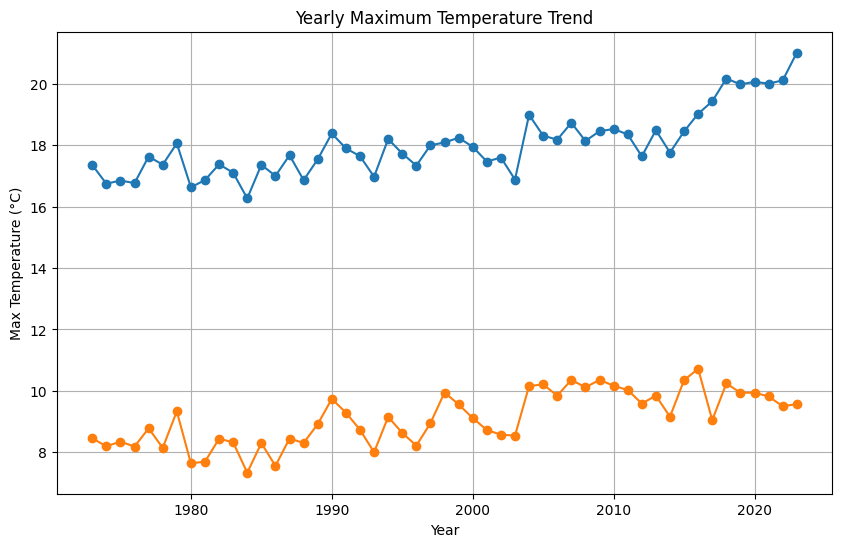

In [15]:
df = yearly_averages.reset_index()
# 1. 年間最高気温の推移の可視化
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['temperature_2m_max'], marker='o')
plt.plot(df['date'], df['temperature_2m_min'], marker='o')
plt.title('Yearly Maximum Temperature Trend')
plt.xlabel('Year')
plt.ylabel('Max Temperature (°C)')
plt.grid(True)
plt.show()

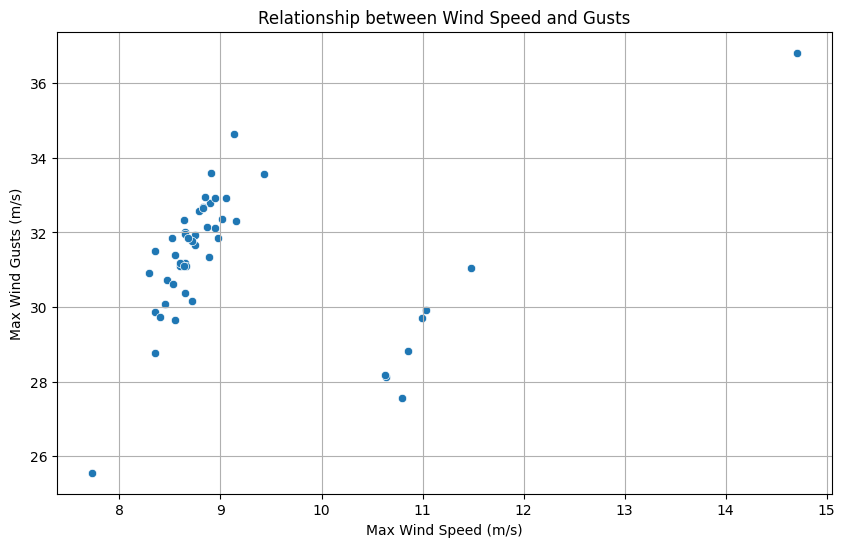

In [37]:
# 2. 風速と突風の関係の可視化
plt.figure(figsize=(10, 6))
sns.scatterplot(x='wind_speed_10m_max', y='wind_gusts_10m_max', data=df)
plt.title('Relationship between Wind Speed and Gusts')
plt.xlabel('Max Wind Speed (m/s)')
plt.ylabel('Max Wind Gusts (m/s)')
plt.grid(True)
plt.show()

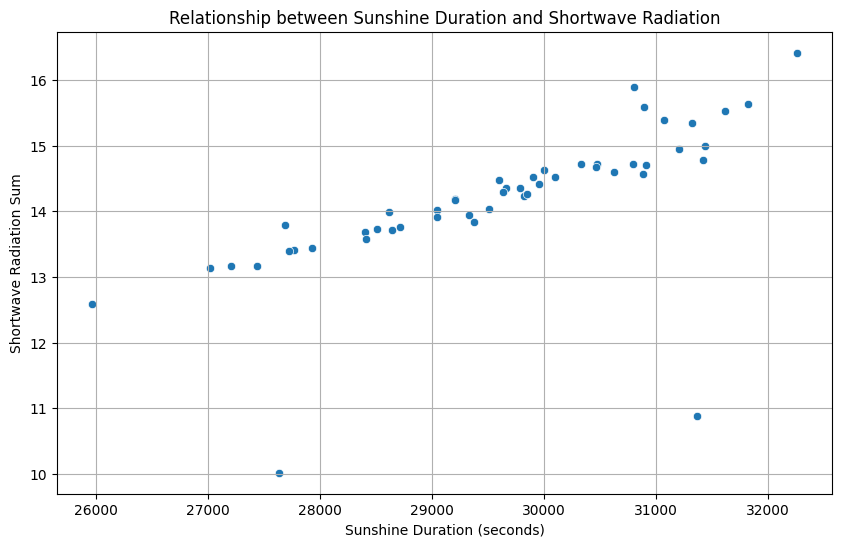

In [38]:
# 3. 日照時間と短波放射の関係の可視化
plt.figure(figsize=(10, 6))
sns.scatterplot(x='sunshine_duration', y='shortwave_radiation_sum', data=df)
plt.title('Relationship between Sunshine Duration and Shortwave Radiation')
plt.xlabel('Sunshine Duration (seconds)')
plt.ylabel('Shortwave Radiation Sum')
plt.grid(True)
plt.show()

# 演習
時間に余裕がある方は、以下の課題に取り組んでみましょう。

## 演習課題1: 別の地域のデータ分析
* 目的: APIを使って別の地域の気象データを取得し、それを分析する。
* 手順: Open Meteo APIを用いて指定した地域のデータを取得し、データフレームに変換する。取得したデータの基本統計量（平均、最大、最小値等）を計算し、分析する。

## 演習課題2: 複数の地域のデータ比較
* 目的: 複数の地域の気象データを比較分析する。
* 手順: 2つ以上の異なる地域の気象データを取得し、それぞれの地域での気温、降水量などの変動を比較分析する。各地域の年間または月間の平均気温などを比較するグラフを作成する。